In [1]:
import os
from PIL import Image
import util.image_import as ii
from glob import glob
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt
from keras.applications import mobilenet
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, RMSprop, SGD
from util.plots import plot_history
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Trick to configure gpu memory dynamically

In [2]:
cfg = K.tf.ConfigProto() # Config to dynamically add memory
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))# set this TensorFlow session as the default session for Keras.

### Subtracting mean and normalizing

In [4]:
mean_image_train = ii.calulate_mean("../dataset3/res_still/train")

def subtract_mean(img):
    return img - mean_image_train

In [5]:
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35),
        preprocessing_function=subtract_mean)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=subtract_mean)

# Train data generator
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=batch_size)

# Test data generator
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=batch_size)

Found 1875 images belonging to 8 classes.
Found 472 images belonging to 8 classes.


## Optimized model single run <span style="color:red"> Done but maybe not converging</span>

In [6]:
model_optimized = Sequential()
model_optimized.add(Flatten(input_shape=(224,224,3)))
model_optimized.add(Dense(256))
model_optimized.add(Activation('relu'))
model_optimized.add(Dense(8))
model_optimized.add(Activation('softmax'))
model_optimized.compile(loss='categorical_crossentropy',
                        optimizer=Adam(lr=1e-4),
                        metrics=['accuracy'])

model_optimized.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               38535424  
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2056      
_________________________________________________________________
activation_2 (Activation)    (None, 8)                 0         
Total params: 38,537,480
Trainable params: 38,537,480
Non-trainable params: 0
_________________________________________________________________


### All classes with both types of catfood

In [7]:
# Checkpoint to save best model
file_path = 'saved_models/fcn_all_classes.e{epoch:02d}-a{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list = [checkpoint]

In [8]:
history_optimized = model_optimized.fit_generator(
                    train_generator,
                    steps_per_epoch=1875 // batch_size,
                    epochs=100,
                    validation_data=test_generator,
                    validation_steps=472 // batch_size,
                    use_multiprocessing=True,
                    workers=4,
                    callbacks=callback_list)


Epoch 1/100
58/58 [==============================] - 32s 548ms/step - loss: 3.0640 - acc: 0.1719 - val_loss: 1.8327 - val_acc: 0.3705

Epoch 00001: val_acc improved from -inf to 0.37054, saving model to saved_models/fcn.e01-a0.37.hdf5
Epoch 2/100
58/58 [==============================] - 38s 656ms/step - loss: 2.4377 - acc: 0.2583 - val_loss: 1.5702 - val_acc: 0.4397

Epoch 00002: val_acc improved from 0.37054 to 0.43973, saving model to saved_models/fcn.e02-a0.44.hdf5
Epoch 3/100
58/58 [==============================] - 42s 726ms/step - loss: 2.0901 - acc: 0.3183 - val_loss: 1.3835 - val_acc: 0.4911

Epoch 00003: val_acc improved from 0.43973 to 0.49107, saving model to saved_models/fcn.e03-a0.49.hdf5
Epoch 4/100
58/58 [==============================] - 40s 688ms/step - loss: 2.2319 - acc: 0.3228 - val_loss: 1.3628 - val_acc: 0.5156

Epoch 00004: val_acc improved from 0.49107 to 0.51562, saving model to saved_models/fcn.e04-a0.52.hdf5
Epoch 5/100
58/58 [==============================] 

58/58 [==============================] - 26s 453ms/step - loss: 0.9061 - acc: 0.6961 - val_loss: 0.7699 - val_acc: 0.7679

Epoch 00040: val_acc improved from 0.76116 to 0.76786, saving model to saved_models/fcn.e40-a0.77.hdf5
Epoch 41/100
58/58 [==============================] - 28s 486ms/step - loss: 0.8339 - acc: 0.6986 - val_loss: 0.8319 - val_acc: 0.7500

Epoch 00041: val_acc did not improve from 0.76786
Epoch 42/100
58/58 [==============================] - 27s 471ms/step - loss: 0.8749 - acc: 0.7084 - val_loss: 0.7723 - val_acc: 0.7612

Epoch 00042: val_acc did not improve from 0.76786
Epoch 43/100
58/58 [==============================] - 29s 494ms/step - loss: 0.8434 - acc: 0.7274 - val_loss: 0.7888 - val_acc: 0.7723

Epoch 00043: val_acc improved from 0.76786 to 0.77232, saving model to saved_models/fcn.e43-a0.77.hdf5
Epoch 44/100
58/58 [==============================] - 26s 446ms/step - loss: 0.9780 - acc: 0.7006 - val_loss: 0.7039 - val_acc: 0.8036

Epoch 00044: val_acc improv

Epoch 82/100
58/58 [==============================] - 31s 531ms/step - loss: 0.5653 - acc: 0.8042 - val_loss: 0.6799 - val_acc: 0.8326

Epoch 00082: val_acc did not improve from 0.86384
Epoch 83/100
58/58 [==============================] - 32s 549ms/step - loss: 0.6173 - acc: 0.7747 - val_loss: 0.5275 - val_acc: 0.8571

Epoch 00083: val_acc did not improve from 0.86384
Epoch 84/100
58/58 [==============================] - 31s 536ms/step - loss: 0.6843 - acc: 0.7802 - val_loss: 0.5817 - val_acc: 0.8393

Epoch 00084: val_acc did not improve from 0.86384
Epoch 85/100
58/58 [==============================] - 32s 547ms/step - loss: 0.5796 - acc: 0.7956 - val_loss: 0.5655 - val_acc: 0.8415

Epoch 00085: val_acc did not improve from 0.86384
Epoch 86/100
58/58 [==============================] - 31s 529ms/step - loss: 0.5698 - acc: 0.8166 - val_loss: 0.5172 - val_acc: 0.8705

Epoch 00086: val_acc improved from 0.86384 to 0.87054, saving model to saved_models/fcn.e86-a0.87.hdf5
Epoch 87/100
58/5

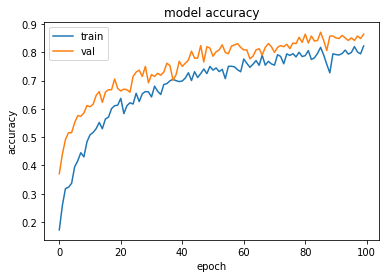

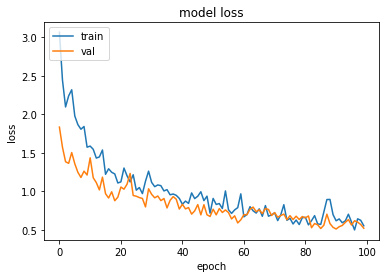

In [10]:
plot_history(history_optimized, save=True, path='nets/feedforward/', name='fcn_all_classes')

### Not trained on catfood_beef
* Catfood beef and catfood salmon is in some picture identical so it is not possible to differentiate between the two classes, thus a model is trained without catfood beef

In [2]:
mean_image_train = ii.calulate_mean("../dataset3/res_still/train", ['catfood_beef'])

def subtract_mean(img):
    return img - mean_image_train

In [3]:
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35),
        preprocessing_function=subtract_mean)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=subtract_mean)

# Train data generator
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        classes=['bun', 'carrots', 'ketchup', 'background', 'arm', 'catfood_salmon', 'potato'],
        batch_size=batch_size)

# Validation data generator
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        classes=['bun', 'carrots', 'ketchup', 'background', 'arm', 'catfood_salmon', 'potato'],
        batch_size=batch_size)


Found 1641 images belonging to 7 classes.
Found 413 images belonging to 7 classes.


In [4]:
model_optimized = Sequential()
model_optimized.add(Flatten(input_shape=(224,224,3)))
model_optimized.add(Dense(256))
model_optimized.add(Activation('relu'))
model_optimized.add(Dense(7))
model_optimized.add(Activation('softmax'))
model_optimized.compile(loss='categorical_crossentropy',
                        optimizer=Adam(lr=1e-4),
                        metrics=['accuracy'])

model_optimized.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               38535424  
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
_________________________________________________________________
activation_2 (Activation)    (None, 7)                 0         
Total params: 38,537,223
Trainable params: 38,537,223
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Checkpoint to save best model
file_path = 'saved_models/fcn_without_catbeef.e{epoch:02d}-a{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callback_list = [checkpoint]

In [6]:
history = model_optimized.fit_generator(
            train_generator,
            steps_per_epoch=1641 // batch_size,
            epochs=100,
            validation_data=test_generator,
            validation_steps=413 // batch_size,
            use_multiprocessing=True,
            workers=4,
            callbacks=callback_list)

Epoch 1/100
51/51 [==============================] - 27s 532ms/step - loss: 2.8646 - acc: 0.2228 - val_loss: 1.4025 - val_acc: 0.4792

Epoch 00001: val_acc improved from -inf to 0.47917, saving model to saved_models/fcn_without_catbeef.e01-a0.48.hdf5
Epoch 2/100
51/51 [==============================] - 28s 545ms/step - loss: 1.9852 - acc: 0.3543 - val_loss: 1.3037 - val_acc: 0.5625

Epoch 00002: val_acc improved from 0.47917 to 0.56250, saving model to saved_models/fcn_without_catbeef.e02-a0.56.hdf5
Epoch 3/100
51/51 [==============================] - 31s 609ms/step - loss: 2.1096 - acc: 0.3665 - val_loss: 1.3078 - val_acc: 0.5677

Epoch 00003: val_acc improved from 0.56250 to 0.56771, saving model to saved_models/fcn_without_catbeef.e03-a0.57.hdf5
Epoch 4/100
51/51 [==============================] - 32s 618ms/step - loss: 1.9097 - acc: 0.3907 - val_loss: 1.0895 - val_acc: 0.5833

Epoch 00004: val_acc improved from 0.56771 to 0.58333, saving model to saved_models/fcn_without_catbeef.e0

Epoch 39/100
51/51 [==============================] - 27s 523ms/step - loss: 0.8887 - acc: 0.7723 - val_loss: 0.6115 - val_acc: 0.8047

Epoch 00039: val_acc did not improve from 0.83594
Epoch 40/100
51/51 [==============================] - 29s 567ms/step - loss: 0.6491 - acc: 0.7999 - val_loss: 0.5339 - val_acc: 0.7995

Epoch 00040: val_acc did not improve from 0.83594
Epoch 41/100
51/51 [==============================] - 27s 522ms/step - loss: 0.7506 - acc: 0.7895 - val_loss: 0.6459 - val_acc: 0.7891

Epoch 00041: val_acc did not improve from 0.83594
Epoch 42/100
51/51 [==============================] - 27s 537ms/step - loss: 0.8086 - acc: 0.7475 - val_loss: 0.5274 - val_acc: 0.8333

Epoch 00042: val_acc did not improve from 0.83594
Epoch 43/100
51/51 [==============================] - 29s 565ms/step - loss: 0.5962 - acc: 0.8032 - val_loss: 0.5716 - val_acc: 0.8359

Epoch 00043: val_acc did not improve from 0.83594
Epoch 44/100
51/51 [==============================] - 28s 547ms/step -

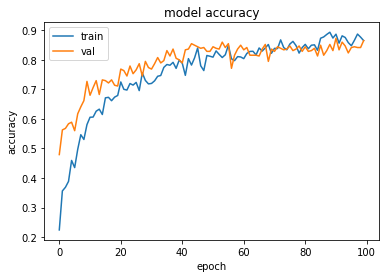

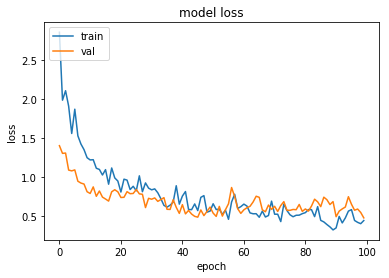

In [7]:
plot_history(history, save=True, path='nets/feedforward/', name='fcn_without_catbeef')

The above training on all classes and training without catfood beef is summurized below:

|Summarize             | Epoch | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy |
|:--------------------:|:-----:|:-------------:|:-----------------:|:---------------:|:-------------------:|
| All Classes          |   86  |     0.5698    |      0.8166       |      0.5172     |        0.8705       |
| Without catfood beef |   91  |     0.3475    |      0.8863       |      0.4914     |        0.8724       |

The results is the best achieved validation accuracy with the respectivly training accuracy. 
<span style="color:red"> Conlclude on these</span>

# Speed batch size and load into ram

**Load from harddrive continuously**

In [4]:
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'



batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35),
        preprocessing_function=subtract_mean)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=subtract_mean)

# Train data generator
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        classes=['bun', 'carrots', 'ketchup', 'background', 'arm', 'catfood_salmon', 'potato'],
        batch_size=batch_size)

# Validation data generator
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        classes=['bun', 'carrots', 'ketchup', 'background', 'arm', 'catfood_salmon', 'potato'],
        batch_size=batch_size)

Found 1641 images belonging to 7 classes.
Found 413 images belonging to 7 classes.


**Load into ram**

In [2]:
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'


X_train, y_train = ii.images_to_numpy_full_class(train_path)
X_test, y_test = ii.images_to_numpy_full_class(test_path)

batch_size = 32
num_classes = 8

# Making datagen for training with normilization, center, and dataugmentation
train_datagen = ImageDataGenerator(
        featurewise_center=True,
        #featurewise_std_normalization=True
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35)
)

# Making datagen for validation and test with normilization
valid_datagen = ImageDataGenerator(
        featurewise_center=True, 
        #featurewise_std_normalization=True
        rescale=1./255
)


y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Required for featurewise normalization
train_datagen.fit(X_train/255.)
valid_datagen.fit(X_train/255.)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=batch_size, shuffle=True)

test_generator = valid_datagen.flow(X_test,
                                     y_test,
                                     batch_size=batch_size, shuffle=True)

print("Found " + str(X_train.shape[0]) + " images belonging to " + str(num_classes) + " classes")
print("Found " + str(X_test.shape[0]) + " images belonging to " + str(num_classes) + " classes")

Found 1875 images belonging to 8 classes
Found 472 images belonging to 8 classes


In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  #  3D activation map -> 1D vector
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
model.add(Dense(8))                                 
model.add(Activation('softmax'))                    
                                                    
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3, epsilon=10e-8),
              metrics=['accuracy'])

In [23]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=1875 // 32,
            epochs=100,
            validation_data=test_generator,
            validation_steps=472 // 32,
            use_multiprocessing=True,
            workers=2)

Epoch 1/100
10/58 [====>.........................] - ETA: 18s - loss: 1.9009 - acc: 0.2344

Process ForkPoolWorker-18:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/home/mikkel/anaconda2/en

KeyboardInterrupt: 

  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/site-packages/PIL/Image.py", line 1804, in resize
    self.load()
  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/site-packages/PIL/ImageFile.py", line 241, in load
    n, err_code = decoder.decode(b)
  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/site-packages/keras/preprocessing/image.py", line 1034, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
KeyboardInterrupt
  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/site-packages/keras/preprocessing/image.py", line 1440, in _get_batches_of_transformed_samples
    x = self.image_data_generator.random_transform(x)
  File "/home/mikkel/anaconda2/envs/NN1.8/lib/python3.6/site-packages/keras/preprocessing/image.py", line 911, in random_transform
    fill_mode=self.fill_mode, c

In [5]:
from util.data_generator import make_data_generator
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'
train_generator, test_generator = make_data_generator(train_path, test_path, load_ram=False)

Found 1875 images belonging to 8 classes.
Found 472 images belonging to 8 classes.
